In [1]:
# A notebook to evaluate GNN explainer performance by calculating Comprehensiveness and Sufficiency 
#     as defined in "BAGEL: A Benchmark for Assessing Graph Neural Network Explanations", by Rathee et al. (2022). 
# 
#     Model training and explanation generation adapted from the original MolRep code by Tim Stols.


In [2]:
# Converted by Tim Stols
# python Explainer_Experiments.py --model_name CMPNN \
#                                                        --attribution_name GradInput \
#                                                        --data_path ../MolRep/Datasets/Metabolism/admet2.1_rlm_merge.csv \
#                                                        --dataset_name RLM \
#                                                        --smiles_col COMPOUND_SMILES \
#                                                        --target_col CLF_LABEL \
#                                                        --task_type Multi-Classification \
#                                                        --multiclass_num_classes 3 \
#                                                        --output_dir ../Outputs

In [50]:
import gc
import os

from pathlib import Path

LOADING_FROM_FILES = True # True if loading in data from pre-existing files
SAMPLE_SIZE = 600 # [0, 2400), for how many molecules comprehensiveness and sufficiency is calculated per explainer 

# output directory for trained model and explanations
OUTPUT_DIR = f'../Outputs/Experiment'
# OUTPUT_DIR = '../Outputs' # original output path, overwrites results

# output the explanations (optionally model) here
output_dir = Path(OUTPUT_DIR)
os.makedirs(OUTPUT_DIR, exist_ok=True)

DATASET = 'Benzene'
# DATASET = '3MR'

# GNN
MODEL = 'CMPNN' # Options:  ['MPNN', 'DMPNN', 'CMPNN', 'GIN', 'ECC', 'GAT', 'DGCNN', 'DiffPool', 'GraphSAGE', 'GraphNet']

# use specified model, else train a new one
# MODELPATH = None
MODELPATH = '../Outputs/Experiment/CMPNN_Benzene_explainer/CMPNN_1_epoch.pt' # using this model because it has non-zero F1 score
# MODELPATH = '../Models/CMPNN_3MR_explainer_20240519_143138.pt'

if MODELPATH is None:
    MODELPATH = os.path.join(OUTPUT_DIR, f"{MODEL}_{DATASET}_explainer", f"{MODEL}.pt")

# explainers used on the trained model, overwritten down below for testing purposes
ATTRIBUTIONS = ['IG', 'GradCAM', 'Random'] # Options: IG CAM MCTS GradInput GradCAM RandomBaseline # this says RandomBaseLine but code expects 'Random'

DATAPATH = '../Datasets/XAI/Benzene/benzene_smiles.csv'
# DATAPATH = '../DataSets/3MR/toy_label_mw350.csv'
SMILESCOL = 'SMILES'
TARGETCOL = 'label'
# TARGETCOL = 'label_full' # for 3MR, on my machine the functions targets the wrong label, even if the offending column is deleted

ATTRIBUTIONPATH = '../Datasets/XAI/Benzene/attributions.npz'
# ATTRIBUTIONPATH = '../DataSets/3MR/attributions.npz'


TASKTYPE = 'Classification' # Can be 'Multi-Classification', 'Classification', 'Regression'
MULTICLASS_NUM_CLASSES = 2 # Can be 3
TESTING = True
SPLITTYPE = 'defined' # Can be 'random', 'scaffold', or other defined for dataset


In [4]:
import rdkit.Chem
from MolRep.Utils.logger import Logger
from MolRep.Explainer.explainerExperiments import ExplainerExperiments
from MolRep.Explainer.explainerDataWrapper import ExplainerDatasetWrapper
from MolRep.Utils.config_from_dict import Grid, Config, DatasetConfig
from pathlib import Path
import os
# from numba.cuda import args

# torch.set_num_threads(1)

# set up the model
data_stats = {
            'name': DATASET,
            'path': DATAPATH,
            'smiles_column': SMILESCOL,
            'target_columns': [TARGETCOL],
            'attribution_path': ATTRIBUTIONPATH,
            'task_type': TASKTYPE,
            'multiclass_num_classes': MULTICLASS_NUM_CLASSES,
            'metric_type': 'rmse' if TASKTYPE == 'Regression' else ['acc', 'auc', 'f1', 'precision', 'recall'],
            'split_type': SPLITTYPE
}

if TESTING:
    data_stats['additional_info'] = {"splits":'SPLIT'}
    
# output for vector groups
data_dir = Path('../MolRep/Data')
split_dir = Path('../MolRep/Splits')
os.makedirs(data_dir, exist_ok=True)
os.makedirs(split_dir, exist_ok=True)

In [5]:
config_file = '../MolRep/Configs/config_{}.yml'.format(MODEL)
model_configurations = Grid(config_file)
model_configuration = Config(**model_configurations[0])
dataset_configuration = DatasetConfig(DATASET, data_dict=data_stats)

CMPNN
{'GIN': <class 'MolRep.Models.graph_based.GIN.GIN'>, 'ECC': <class 'MolRep.Models.graph_based.ECC.ECC'>, 'DGCNN': <class 'MolRep.Models.graph_based.DGCNN.DGCNN'>, 'DiffPool': <class 'MolRep.Models.graph_based.DiffPool.DiffPool'>, 'GraphSAGE': <class 'MolRep.Models.graph_based.GraphSAGE.GraphSAGE'>, 'GAT': <class 'MolRep.Models.graph_based.GAT.GAT'>, 'GraphNet': <class 'MolRep.Models.graph_based.GraphNet.GraphNet'>, 'MPNN': <class 'MolRep.Models.graph_based.MPNN.MPNN'>, 'CMPNN': <class 'MolRep.Models.graph_based.CMPNN.CMPNN'>, 'DMPNN': <class 'MolRep.Models.graph_based.DMPNN.DMPNN'>, 'MAT': <class 'MolRep.Models.sequence_based.MAT.MAT'>, 'CoMPT': <class 'MolRep.Models.sequence_based.CoMPT.CoMPT'>, 'BiLSTM': <class 'MolRep.Models.sequence_based.BiLSTM.BiLSTM'>, 'SALSTM': <class 'MolRep.Models.sequence_based.SALSTM.SALSTM'>, 'Transformer': <class 'MolRep.Models.sequence_based.Transformer.Transformer'>, 'VAE': <class 'MolRep.Models.unsupervised_based.VAE.VAE'>, 'RandomForest': <class

In [6]:
# export path: model + dataset name
exp_path = os.path.join(output_dir, f'{model_configuration.exp_name}_{dataset_configuration.exp_name}_explainer')

# dataset_config: configuration of the model
# model_name: name of the model
# split_dir: path to defined splits of the dataset
# features_dir: path to data directory
dataset = ExplainerDatasetWrapper(dataset_config=dataset_configuration,
                                  model_name=model_configuration.exp_name,
                                  split_dir=split_dir, features_dir=data_dir)

# set up the experiment
explainer_experiment = ExplainerExperiments(model_configuration, dataset_configuration, exp_path)

In [7]:
import pandas as pd
import re
# import torch

# to load a model from a file without having used it, need to instantiate it first
# model = CMPNN(model_configuration)
# state_dict = torch.load(MODELPATH)
# model.load_state_dict(state_dict)

# Options: IG CAM MCTS GradInput GradCAM RandomBaseline # says RandomBaseLine but code expects 'Random'
ATTRIBUTIONS = []

atom_importances = []
explainer_accuracies = []

if LOADING_FROM_FILES :
    LOGGER_BASE = os.path.join(OUTPUT_DIR, "Logger", f"{DATASET}_explainer")
    logger = Logger(str(os.path.join(LOGGER_BASE, f"{MODEL}_{DATASET}_explainer_by_experiment.log")), mode='a')
    
    ### TODO on first run, uncomment, on subsequent runs can leave commented out ###
    # _, _, _ = explainer_experiment.molecule_importance(dataset=dataset, attribution=ATTRIBUTIONS[0], logger=logger, other={'model_path':MODELPATH}, testing=TESTING)
    
    # read in used explainers
    explainer_accs_path = os.path.join(OUTPUT_DIR, f"{MODEL}_{DATASET}_explainer" , f"explainer_accuracies.csv")
    explainer_accuracies_df = pd.read_csv(explainer_accs_path) # used for looking at, nothing else
    
    for e in explainer_accuracies_df['explainer']:
        ATTRIBUTIONS.append(e)
    
    # get atom importances per explainer
    for ATTRIBUTION in ATTRIBUTIONS:
        atom_imp_for_expl = []
        
        imp_path = os.path.join(output_dir, f"{MODEL}_{DATASET}_explainer", "SVG", f"{ATTRIBUTION}_{model_configuration['num_epochs']}_epochs" , "importances.csv")

        # atom importances are given as a string of an array of floats 
        importance = pd.read_csv(imp_path)['Atom_importance']
        
        for _, row in importance.items():
            # remove brackets and newlines
            clean_imp = re.sub(r'[\[\]\n]', '', row).strip()
            
            # split by whitespace and convert to float
            float_imps = [float(x) for x in clean_imp.split()]
            atom_imp_for_expl.append(float_imps)

        atom_importances.append(atom_imp_for_expl)    
    
else: 
    ATTRIBUTIONS = ['IG', 'GradCAM', 'Random']
    # generate explanations for each explainer
    for ATTRIBUTION in ATTRIBUTIONS:
        LOGGER_BASE = os.path.join(OUTPUT_DIR, "Logger", f"{DATASET}_explainer")
        logger = Logger(str(os.path.join(LOGGER_BASE, f"{MODEL}_{DATASET}_explainer_by_{ATTRIBUTION}.log")), mode='a')
        
        # define path for graphics
        svg_dir = os.path.join(OUTPUT_DIR, f"{MODEL}_{DATASET}_explainer", "SVG", f"{ATTRIBUTION}_{model_configuration['num_epochs']}_epochs")
        os.makedirs(svg_dir, exist_ok=True)
    
        ### comment out if a model exists and want to use it with all models, else trains a new one for each ###
        # explainer_experiment.run_valid(dataset, ATTRIBUTION, logger=logger, other={'model_path':MODELPATH})
    
        ## if model doesn't exist, train a new one
        # if not os.path.exists(MODELPATH):
        #     explainer_experiment.run_valid(dataset, ATTRIBUTION, logger=logger, other={'model_path':MODELPATH})
        
        # generate attributions; bond_importance is None in all the tests I ran
        results, atom_importance, bond_importance = explainer_experiment.molecule_importance(dataset=dataset, attribution=ATTRIBUTION, logger=logger, other={'model_path':MODELPATH}, testing=TESTING)
        
        if DATASET in ['hERG', 'CYP3A4']:
            attribution_results, opt_threshold = explainer_experiment.evaluate_cliffs(dataset, atom_importance, bond_importance)
        else:
            binary = True if ATTRIBUTION == 'MCTS' else False
            #TODO "not working, because ATTRIBUTIONPATH is not set and attributions are not saved"
            attribution_results, opt_threshold = explainer_experiment.evaluate_attributions(dataset, atom_importance, bond_importance, binary=binary)
         
        # creates visualizations from the datasets and outputs them to svg_dir
        explainer_experiment.visualization(dataset, atom_importance, bond_importance, svg_dir=svg_dir, testing=TESTING)
    
        # write the results, atom importances to a file
        df = pd.DataFrame(
            {'SMILES': dataset.get_smiles_list(), 'Atom_importance': atom_importance, 'Bond_importance':bond_importance}
        )
        df.to_csv(os.path.join(svg_dir, "importances.csv"), index=False)
    
        # create an object from the pre-established metrics, add to list (include model results to ensure they're all the same)
        acc = {"explainer" : ATTRIBUTION,
               "model" : MODEL,
                "epochs" : model_configuration['num_epochs'],
                "acc" : results['acc'],
                "auc" : results['auc'], 
                "f1" : results['f1'], 
                "precision" : results['precision'], 
                "recall" : results['recall'], 
                "Attribution AUROC" : attribution_results['Attribution AUROC'], 
                "Attribution F1" : attribution_results['Attribution F1'], 
                "Attribution ACC" : attribution_results['Attribution ACC'], 
                "Attribution Precision" : attribution_results['Attribution Precision'], 
                "Attribution AUROC Mean" : attribution_results['Attribution AUROC Mean'], 
                "Attribution ACC Mean" : attribution_results['Attribution ACC Mean'] }
        explainer_accuracies.append(acc)
    
        # add atom importances to a list, fetch them by index of attributions on the list used
        # importance = {"Atom_importance" : atom_importance}
        atom_importances.append(atom_importance)
       
    # TODO store these in a file
    explainer_accuracies_df = pd.DataFrame(explainer_accuracies)
    
    # dataframe for storing atom importances per explainer in a file later
    importances_df = pd.DataFrame(atom_importances)

In [8]:
import copy

# path to model and explanations

x = os.path.join(output_dir, f"{MODEL}_{DATASET}_explainer", "SVG", f"IG_{model_configuration['num_epochs']}_epochs" , "importances.csv")
# IMPORTANCES_PATH = '../Outputs/20240524_164403/CMPNN_Benzene_explainer/SVG/IG_1_epochs/importances.csv' 

# os.path.join(output_dir, f"{MODEL}_{DATASET}_explainer", "SVG", f"{ATTRIBUTION}_{DATASET}_explainer" , "importances.csv")
IMPORTANCES_PATH = x


# svg_dir = os.path.join(OUTPUT_DIR, f"{MODEL}_{DATASET}_explainer", "SVG", f"{ATTRIBUTION}_{model_configuration['num_epochs']}_epochs")
# df.to_csv(os.path.join(svg_dir, ), index=False)

# df = pd.read_csv(IMPORTANCES_PATH)
# print(df['Atom_importance'].iat[3])

# TODO write explainer_accuracies and atom importances to a file if they arent already

# y = os.path.join(output_dir, f"{MODEL}_{DATASET}_explainer", f"{model_configuration['num_epochs']}_epochs")
# os.makedirs(y, exist_ok=True)

# df.to_csv(os.path.join(svg_dir, "importances.csv"), index=False)

# explainer_accuracies_df.to_csv(y, "explainer_accuracies.csv", index=False)
explainer_accuracies_df

,explainer,model,epochs,acc,auc,f1,precision,recall,Attribution AUROC,Attribution F1,Attribution ACC,Attribution Precision,Attribution AUROC Mean,Attribution ACC Mean
0,IG,CMPNN,1,0.7475,0.84503,0.772693,0.707904,0.850537,0.948258,0.270941,0.826335,0.409868,0.902073,0.822777
1,GradCAM,CMPNN,1,0.7475,0.84503,0.772693,0.707904,0.850537,0.946488,0.232464,0.816451,0.386729,0.894481,0.811813
2,Random,CMPNN,1,0.7475,0.84503,0.772693,0.707904,0.850537,0.502484,0.000000,0.815321,0.000000,0.501554,0.804673


In [9]:
import numpy as np
def convert_from_test_to_real_idx(idx):
    """Converts the index used in the test set to the index in the whole dataset."""    
    smile = dataset.get_smiles_list(testing=True)[idx]
    
    data = dataset.whole_data_df 
    return data.loc[(data == smile).any(axis=1)].index[0]

def convert_real_idx_to_test_idx(idx):
    """Converts an index from the big dataset to the one in the test set"""
    ds = dataset.whole_data_df 
    ts = dataset.get_smiles_list()
    smile = ds.iloc[idx]['SMILES']

    return np.where(ts == smile)[0][0]

In [10]:
p = convert_real_idx_to_test_idx(11998)
print(p)
c = convert_from_test_to_real_idx(2399)
print(c)

2399
11998


In [11]:
def split_molecule(mol_idx:int, explainer='IG', threshold=1e-4, from_whole_data=False, strict_split=False):
    """Splits the given molecule into explaining and non-explaining SMILES based on given explanation, returns those and the SMILES of the molecule. Threshold value is the same as in explainerExperiments.py visualization(). from_whole_data True if using idx in the whole dataset, False if looking by index in test set"""
    
    if from_whole_data:
        smile = dataset.whole_data_df.SMILES.iat[mol_idx]
        mol_idx = convert_real_idx_to_test_idx(mol_idx)
    else:
        # testing = True by default
        smile = dataset.get_smiles_list(testing=True)[mol_idx]
    
    # atom importances depend on what explainer method is used, mol_idx is convenient
    expl_idx = ATTRIBUTIONS.index(explainer)
    a_importances = atom_importances[expl_idx][mol_idx]

    original_mol = rdkit.Chem.RWMol(rdkit.Chem.MolFromSmiles(smile))
     
    explaining_atom_idxs = []
    expl_edge_atom_idxs = []
    non_explaining_atom_idxs = []
    
    for idx in range(len(original_mol.GetAtoms())):
        if a_importances[idx] < threshold:
            non_explaining_atom_idxs.append(idx)
        else:
            explaining_atom_idxs.append(idx)
    
    # reverse because removing atoms causes indices of others to shift
    non_explaining_atom_idxs.reverse()
    explaining_atom_idxs.reverse()
    
    # number of atoms in explanation vs whole molecule 
    exp_length = len(explaining_atom_idxs) / ( len(explaining_atom_idxs) + len(non_explaining_atom_idxs))
    
    explaining_bonds = []
    non_explaining_bonds = []
    
    for bond in original_mol.GetBonds():
        start = bond.GetBeginAtomIdx()
        end = bond.GetEndAtomIdx()
        
        # if an explaining atom connects to a nonexplaining atom, it's an edge atom
        if start not in explaining_atom_idxs and end in explaining_atom_idxs:
            expl_edge_atom_idxs.append(end)
                
        if end not in explaining_atom_idxs and start in explaining_atom_idxs:
            expl_edge_atom_idxs.append(start)
        
        # if both end and start in explaining atoms, the edge is explaining 
        if start in explaining_atom_idxs and end in explaining_atom_idxs:
            explaining_bonds.append((start, end))
        else:
            # non explaining bond found
            non_explaining_bonds.append((start, end))
             
    expl_edge_atom_idxs = list(set(expl_edge_atom_idxs))
    
    # print("expl ", explaining_atom_idxs)
    # print("edge ", expl_edge_atom_idxs)
    # print("non ", non_explaining_atom_idxs )
     
    # explaining molecule has non-explaining bonds and atoms removed
    explaining_mol = copy.deepcopy(original_mol)
    for (i, j) in non_explaining_bonds:
        # print(i, j)
        explaining_mol.RemoveBond(i, j)
        explaining_mol.RemoveBond(j, i)
    
    for idx in non_explaining_atom_idxs:
        explaining_mol.RemoveAtom(idx)

    explaining_smile = rdkit.Chem.MolToSmiles(explaining_mol)
    
    # non-explaining molecule removes explaining bonds and atoms not on the edge of the explanation 
    non_explaining_mol = copy.deepcopy(original_mol)    
    
    # remove explaining bonds 
    for (i, j) in explaining_bonds:
        non_explaining_mol.RemoveBond(i, j)
        non_explaining_mol.RemoveBond(j, i)

    # if strict_split false, leads to situations where nonexplaining fragments can be connected by one explaining atom e.g. mol 93
    if strict_split:
        for i in [e for e in explaining_atom_idxs]:
            non_explaining_mol.RemoveAtom(i)    
    else:
        for i in [e for e in explaining_atom_idxs if e not in expl_edge_atom_idxs]:
            non_explaining_mol.RemoveAtom(i)
    
    non_explaining_smile = rdkit.Chem.MolToSmiles(non_explaining_mol)
    
    return smile, explaining_smile, non_explaining_smile, exp_length

In [12]:
s, e, n, m = split_molecule(128, from_whole_data=False, strict_split=False)
s1, e1, n1, m1 = split_molecule(128, from_whole_data=False, strict_split=True)

from rdkit import Chem
from rdkit.Chem import Draw
# 168
print(s)
print(e, "\t", e1)
print(n, "\t", n1)

COc1ccc2cc(ccc2c1)c1cc(ccn1)C(=O)[O-]
ccc(cc-c1ccc2ccccc2c1)C(=O)[O-] 	 ccc(cc-c1ccc2ccccc2c1)C(=O)[O-]
COc.cnc 	 CO.n


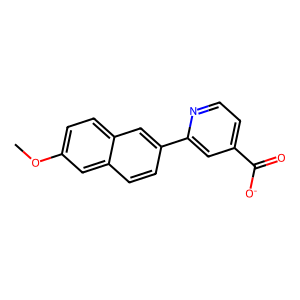

In [13]:
Draw.MolToImage(Chem.MolFromSmiles(s))
# Draw.MolToImage(Chem.MolFromSmiles(e1))
# Draw.MolToImage(Chem.MolFromSmiles(n))
# print(ATTRIBUTION) c1nccN1

In [14]:
# Draw.MolToImage(Chem.MolFromSmiles(n))
# 17 => 93.png

In [15]:
import torch
from MolRep.Featurization.MPNN_embeddings import MolGraph, BatchMolGraph
from rdkit.Chem import MolFromSmiles, rdmolops

def tensors_to_device(smile, batch):
    """Sets nodes, edges, a2b, b2a and adjacency matrix tensors of a molecule to the device"""
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    adj = rdmolops.GetAdjacencyMatrix(MolFromSmiles(smile))
    
    features = {
        'nodes' : batch.f_atoms, 
        'edges' : batch.f_bonds,
        'a2b' : batch.a2b,
        'b2a' : batch.b2a,
        'adjacency' : torch.FloatTensor(adj) 
    }
    
    for i in features:
        features[i].to(device)
        
    return features['nodes'], features['edges'], features['a2b'], features['b2a'], features['adjacency']

In [16]:
import re
def clean_smile(smile:str) -> str:
    """Takes a (fragmented) SMILES as input and returns concatenated valid fragments of it. Does nothing if input is already valid.
    e.g: C.CC.F.O.n.n -> C.CC.F.O
    """
    cs = ""
    # 1. split n/explanations into a list
    subm = smile.split('.')
    
    # 2. try to convert the pieces into a molgraph
    # if success, append to a new string cs (cut string)
    for (i, sm) in enumerate(subm): 
        try:
            MolGraph(sm)
            cs += sm
            cs += '.'
        except:
            cs += '.'
            continue

    # remove repetitions and the first and last period from the string
    cs = re.sub("\.+", ".", cs)
    # ReGeX from https://stackoverflow.com/a/3331982
    cs = re.sub("\.([^.]*)$", "", cs)
    cs = re.sub("(^\.)", "", cs)
    return cs

In [17]:
def clear_gpu_memory():
    torch.cuda.empty_cache()
    gc.collect()

EXPERIMENT_MODEL = MODELPATH

In [18]:
def comp_and_suff(idx, explainer = 'IG', from_all_data=False, modified_formula=True, strict_split=False) :
    """Calculates comprehensiveness and sufficiency for a molecule with index idx, given explanation e, returns an object with mol_idx, all the smiles (cleaned and uncleaned), predictions for everything, comprehensiveness and sufficiency, and proportion of explanation vs original molecule. from_all_data True if fetching smile from the whole set, False if from test set."""
    
    # TODO move this out so no need to get the same model every time
    model = explainer_experiment.get_model(dataset, other={'model_path':EXPERIMENT_MODEL})
    model.eval() # set model to evaluation mode

    smile, explaining_smile, non_explaining_smile, exp_length = split_molecule(idx, explainer, from_whole_data=from_all_data, strict_split=strict_split)
    
    # clean up the smiles, split may have created invalid molecules
    clean_smiles = list(map(clean_smile, [smile, explaining_smile, non_explaining_smile]))

    preds = []
    for (i, cs) in enumerate(clean_smiles):
        if cs == "": # don't predict empty strings
            # if no non-explaining, then comp is f(g) = great, because the whole molecule explains the prediction!
            # if no explaining, suff is f(g) = maybe good?, because there's nothing to explain why prediction was made?
            
            # none to predict to begin with != none being valid
            if cs == [smile, explaining_smile, non_explaining_smile][i]:
                preds.append([0]) # no (non)explaining to begin with is a-okay     
            else:
                preds.append([None]) # no valid strings after cleaning up less so
            continue
            
        subpreds = []
        
        if modified_formula:
            splits = cs.split('.')
            for split in splits:
            
                # 3. convert s to molgraph
                try:
                    mol = MolGraph(split)
                    g_input = BatchMolGraph( [mol])
                    atoms, bonds, a2b, b2a, adjacency = tensors_to_device(cs, g_input)
            
                    with torch.no_grad():
                        # TODO investigate None params?
                        #   Args for mol2graph:
                        # - mols: A list of SMILES or a list of RDKit molecules.
                        # - atom_descriptors_batch: A list of 2D numpy array containing additional atom descriptors to featurize the molecule
                        subpred = model([[split], None, None]).item()
            
                    subpreds.append(subpred)
                except:
                    # If model couldn't predict the subgraph for whatever weird reason
                    # I don't know why this would happen, but evidently it does happen
                    subpreds.append(None)
        else:
            try:
                mol = MolGraph(cs)
                g_input = BatchMolGraph( [mol])
                atoms, bonds, a2b, b2a, adjacency = tensors_to_device(cs, g_input)
        
                with torch.no_grad():
                    # TODO investigate None params?
                    #   Args for mol2graph:
                    # - mols: A list of SMILES or a list of RDKit molecules.
                    # - atom_descriptors_batch: A list of 2D numpy array containing additional atom descriptors to featurize the molecule
                    subpred = model([[cs], None, None]).item()
        
                subpreds.append(subpred)
            except:
                # If model couldn't predict the subgraph for whatever weird reason
                # I don't know why this would happen, but evidently it does happen
                subpreds.append(None)
            
        preds.append(subpreds)
    
    converted_idx = idx
    if not from_all_data:
        converted_idx = convert_from_test_to_real_idx(idx)
    
    try:
        mol_pred = preds[0][0] # prediction of original molecule, there is only one so do nothing
        
        if modified_formula: 
            e_pred = None if preds[1] == [None] else sum(preds[1]) / len(preds[1]) # prediction of explaining molecules : take the mean
            n_pred = None if preds[2] == [None] else sum(preds[2]) # prediction of non-explaining molecules : sum
        else:
            e_pred = None if preds[1] == [None] else preds[1][0]
            n_pred = None if preds[2] == [None] else preds[2][0]
        
        # f = model prediction given a smile
        # comp = f(smile) - f(non_explaining_smile)
        # suff = f (smile) - f(explaining_smile)
        
        comp = mol_pred - n_pred if n_pred is not None else None
        suff = mol_pred - e_pred if e_pred is not None else None
        
        result = {
            "explainer" : explainer,
            "mol_idx": idx if from_all_data else converted_idx,
            "smile" : smile,
            "explaining_smile" : explaining_smile,
            "clean_explanation" : clean_smiles[1],
            "non_explaining_smile" : non_explaining_smile,
            "clean_nonexplanation": clean_smiles[2],
            "mol_pred": mol_pred,
            "e_pred": e_pred,
            "ne_pred": n_pred,
            "comp" : comp,
            "suff" : suff,
            "expl length": exp_length
        }
        
        return result
    except:
        # print 
        print(preds, " idx in dataset: ", converted_idx , " idx in test set: ", idx)


In [19]:
def comp_suff_all_variations(idx):
    van_strict = comp_and_suff(idx, modified_formula=False, from_all_data=True, strict_split=True)
    van_soft = comp_and_suff(idx, modified_formula=False, from_all_data=True, strict_split=False)
    mod_strict = comp_and_suff(idx, from_all_data=True, strict_split=True)
    mod_soft = comp_and_suff(idx, from_all_data=True, strict_split=False)
    
    return pd.DataFrame([van_strict, van_soft, mod_strict, mod_soft])

In [20]:
# c = comp_suff_all_variations(168)
# d = comp_suff_all_variations(238)

In [21]:
# e = comp_suff_all_variations(11997)

# 1018 has two rings, 509 has one, so does 168
# 
# van_1018_strict = comp_and_suff(1018, modified_formula=False, from_all_data=True, strict_split=True)
# van_1018_soft = comp_and_suff(1018, modified_formula=False, from_all_data=True, strict_split=False)
# mod_1018_strict = comp_and_suff(1018, from_all_data=True, strict_split=True)
# mod_1018_soft = comp_and_suff(1018, from_all_data=True, strict_split=False)
# print(split_molecule(3, from_whole_data=False)) # mol idx is number 3 in test set i.e. mol 13
# print(split_molecule(3, from_whole_data=True)) # mol idx is number 3 in whole set
# Draw.MolToImage()

In [22]:
# c # 168
# print(van_3)
# print(mod_3)

In [23]:
# d # 238

In [24]:
# e # 1018

In [103]:
def get_samples():
    """If a sample file doesn't exist, create new samples and save to file, else read from a file."""
    try:
        samples = pd.read_csv(os.path.join(exp_path, 'samples.csv'))
        return samples.to_numpy().flatten()
    except:
        samples = np.random.choice(len(dataset.get_smiles_list(testing=True)), SAMPLE_SIZE, replace=False)
        samples = np.sort(samples, axis=0)
        samples_df = pd.DataFrame(samples)
        samples_df.to_csv(os.path.join(exp_path, 'samples.csv'), header=True, index=False)
        return samples

SAMPLES = get_samples()

In [104]:
def comp_and_suff_data(explainer='IG', sample_size=SAMPLE_SIZE, random_samples=False):
    """Accumulates the comp and suff for molecules within the test set of the provided dataset. Random_samples True if using pre-generated random samples, else iterates molecules in order."""
    c_and_s = []
    
    n = min(sample_size, len(dataset.get_smiles_idxs(testing=True)))
    
    # if using random samples, iterate through them
    if random_samples:
        for i in SAMPLES:
            torch.cuda.empty_cache() # please be enough to allow things to run smoothly
            vals = comp_and_suff(i, explainer)
            c_and_s.append(vals)     
    # we only care about the index, because we're getting things by index in the test set
    else:
        for i in range(n):
            torch.cuda.empty_cache() # please be enough to allow things to run smoothly
            vals = comp_and_suff(i, explainer)
            c_and_s.append(vals)
    return c_and_s


In [102]:

# c = comp_and_suff_data()
# pd.DataFrame(c)

In [105]:
# save results of comp-suff for transparency

def comp_and_suff_for_all_explainers(explainers, sample_size=SAMPLE_SIZE, random_samples=False):
    """Calculates comp and suff for all explainers, given a list of explainers and a full matrix of atom importances. Struggles with 3 explainers and higher number of samples, 100 and 200 are okay."""
    comps = []
    
    for (i, explainer) in enumerate(explainers):
        torch.cuda.empty_cache() # please be enough to allow things to run smoothly
        # print(i, explainer)
        
        if random_samples:
            comp = comp_and_suff_data(explainer=explainer, sample_size=sample_size, random_samples=True)
        else:
            comp = comp_and_suff_data(explainer=explainer, sample_size=sample_size, random_samples=False)
        
        comps.append(comp)
    return comps

In [25]:
# c_and_s = comp_and_suff_for_all_explainers(ATTRIBUTIONS, random_samples=True)
c_and_s_IG = comp_and_suff_data(dataset, 'IG', random_samples=True)

Moving model to cuda
Moving model to cuda
Moving model to cuda
Moving model to cuda
Moving model to cuda
Moving model to cuda
Moving model to cuda
Moving model to cuda
Moving model to cuda
Moving model to cuda
Moving model to cuda
Moving model to cuda
Moving model to cuda
Moving model to cuda
Moving model to cuda
Moving model to cuda
Moving model to cuda
Moving model to cuda
Moving model to cuda
Moving model to cuda
Moving model to cuda
Moving model to cuda
Moving model to cuda
Moving model to cuda
Moving model to cuda
Moving model to cuda
Moving model to cuda
Moving model to cuda
Moving model to cuda
Moving model to cuda
Moving model to cuda
Moving model to cuda
Moving model to cuda
Moving model to cuda
Moving model to cuda
Moving model to cuda
Moving model to cuda
Moving model to cuda
Moving model to cuda
Moving model to cuda
Moving model to cuda
Moving model to cuda
Moving model to cuda
Moving model to cuda
Moving model to cuda
Moving model to cuda
Moving model to cuda
Moving model 

In [26]:
pd.DataFrame(c_and_s[0])

,explainer,mol_idx,smile,explaining_smile,clean_explanation,non_explaining_smile,clean_nonexplanation,mol_pred,e_pred,ne_pred,comp,suff,expl length
0,IG,13,Cn1cncc1CCNC(=O)c1cc(cnc1)F,c.cc.cccc(c)CN,,C=O.cF.cnc.cncn(C)cCCN,C=O,0.546673,NaN,0.475721,0.070952,NaN,0.555556
1,IG,100,C[NH+](C)[C@@H]1CC[C@@H](C1)NC(=O)CC1(CCCCC1)O,NC=O,NC=O,CCC1(O)CCCCC1.C[NH+](C)[C@@H]1CC[C@H](N)C1,CCC1(O)CCCCC1.C[NH+](C)[C@@H]1CC[C@H](N)C1,0.432388,0.490961,0.860539,-0.428151,-0.058574,0.157895
2,IG,180,CC1=C[C@H]2C3=C(CCN(C3)C(=O)C)N=C2C=C1,C.C=C.C=CC=CC,C.C=C.C=CC=CC,CC.CC(=O)N1CCCN=C[C@@H](C)CC1,CC.CC(=O)N1CCCN=C[C@@H](C)CC1,0.494252,0.489388,0.907384,-0.413132,0.004863,0.470588
3,IG,291,c1cc(ccc1/C=C/C(=O)c1ccc(cc1)F)O,O=C(/C=C/c1ccc(O)cc1)c1ccccc1,O=C(/C=C/c1ccc(O)cc1)c1ccccc1,cF,,0.575858,0.580530,NaN,NaN,-0.004672,0.944444
4,IG,498,Cc1ncc(s1)[C@@H](C)[NH2+][C@H](C)CCSC,c.cc,,cnc(C)sc[C@@H](C)[NH2+][C@H](C)CCSC,,0.476645,NaN,NaN,NaN,NaN,0.200000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,IG,11821,c1cnccc1CNc1ccnc(n1)C(F)(F)F,c.cccN.ccccc,,cCN.cnc.cnc(nc)C(F)(F)F,,0.546284,NaN,NaN,NaN,NaN,0.555556
196,IG,11838,Cc1cc[nH+]c(c1)NCCNC(=O)c1ccccc1NCC(=O)[O-],NC(=O)c1ccccc1N.Nc1cccc[nH+]1.O=C[O-],NC(=O)c1ccccc1N.Nc1cccc[nH+]1.O=C[O-],CCN.Cc.NCCN,CCN.NCCN,0.551802,0.543837,0.898572,-0.346771,0.007965,0.833333
197,IG,11865,CCCOc1ccc(cc1)CNC(=O)C[N@H+](C)Cc1cnn(c1)C,NC=O.c1ccccc1.cccn,NC=O.c1ccccc1,CCCOc.CC[NH+](C)Cc.cCN.cnnC,,0.523213,0.535968,NaN,NaN,-0.012755,0.541667
198,IG,11868,Cc1c(nnc(c1C#N)N1CCN(CC1)Cc1nc(n[nH]1)C)C,c.c[nH].cccc,,Cc.CcnncN1CCN(Ccnc(C)n[nH])CC1.cC#N,,0.502142,NaN,NaN,NaN,NaN,0.304348


In [27]:
pd.DataFrame(c_and_s[1])

,explainer,mol_idx,smile,explaining_smile,clean_explanation,non_explaining_smile,clean_nonexplanation,mol_pred,e_pred,ne_pred,comp,suff,expl length
0,GradCAM,13,Cn1cncc1CCNC(=O)c1cc(cnc1)F,c.cc.cccc(c)C(N)=O,,cF.cnc.cncn(C)cCCN,,0.546673,NaN,NaN,NaN,NaN,0.611111
1,GradCAM,100,C[NH+](C)[C@@H]1CC[C@@H](C1)NC(=O)CC1(CCCCC1)O,NC=O,NC=O,CCC1(O)CCCCC1.C[NH+](C)[C@@H]1CC[C@H](N)C1,CCC1(O)CCCCC1.C[NH+](C)[C@@H]1CC[C@H](N)C1,0.432388,0.490961,0.860539,-0.428151,-0.058574,0.157895
2,GradCAM,180,CC1=C[C@H]2C3=C(CCN(C3)C(=O)C)N=C2C=C1,C=C.C=CC=CC.NC=O,C=C.C=CC=CC.NC=O,CC.CC.C[C@@H]1C=NCCCNCC1,CC.CC.C[C@@H]1C=NCCCNCC1,0.494252,0.495684,1.357424,-0.863172,-0.001433,0.588235
3,GradCAM,291,c1cc(ccc1/C=C/C(=O)c1ccc(cc1)F)O,O=C(/C=C/c1ccc(O)cc1)c1ccc(F)cc1,O=C(/C=C/c1ccc(O)cc1)c1ccc(F)cc1,,,0.575858,0.576942,0.000000,0.575858,-0.001083,1.000000
4,GradCAM,498,Cc1ncc(s1)[C@@H](C)[NH2+][C@H](C)CCSC,c.cc,,cnc(C)sc[C@@H](C)[NH2+][C@H](C)CCSC,,0.476645,NaN,NaN,NaN,NaN,0.200000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,GradCAM,11821,c1cnccc1CNc1ccnc(n1)C(F)(F)F,c.cccN.ccccc,,cCN.cnc.cnc(nc)C(F)(F)F,,0.546284,NaN,NaN,NaN,NaN,0.555556
196,GradCAM,11838,Cc1cc[nH+]c(c1)NCCNC(=O)c1ccccc1NCC(=O)[O-],NC(=O)c1ccccc1N.Nc1cccc[nH+]1.O=C[O-],NC(=O)c1ccccc1N.Nc1cccc[nH+]1.O=C[O-],CCN.Cc.NCCN,CCN.NCCN,0.551802,0.543837,0.898572,-0.346771,0.007965,0.833333
197,GradCAM,11865,CCCOc1ccc(cc1)CNC(=O)C[N@H+](C)Cc1cnn(c1)C,NC=O.c1ccccc1.cccn,NC=O.c1ccccc1,CCCOc.CC[NH+](C)Cc.cCN.cnnC,,0.523213,0.535968,NaN,NaN,-0.012755,0.541667
198,GradCAM,11868,Cc1c(nnc(c1C#N)N1CCN(CC1)Cc1nc(n[nH]1)C)C,c.c[nH].ccccN,,Cc.Cc(n[nH])ncCN1CCNCC1.cC#N.cnncC,,0.502142,NaN,NaN,NaN,NaN,0.347826


In [28]:
pd.DataFrame(c_and_s[2])

,explainer,mol_idx,smile,explaining_smile,clean_explanation,non_explaining_smile,clean_nonexplanation,mol_pred,e_pred,ne_pred,comp,suff,expl length
0,Random,13,Cn1cncc1CCNC(=O)c1cc(cnc1)F,C.Cnc(C)cn.F.n,C.F,CCNC(=O)c1cncc(F)c1.ncn,CCNC(=O)c1cncc(F)c1,0.546673,0.473629,0.542229,0.004444,0.073044,0.500000
1,Random,100,C[NH+](C)[C@@H]1CC[C@@H](C1)NC(=O)CC1(CCCCC1)O,CC.CCNC.C[NH+]C.O,CC.CCNC.C[NH+]C.O,CCCC(O)(CC)CC=O.CC[C@@H]([NH+])CC,CCCC(O)(CC)CC=O.CC[C@@H]([NH+])CC,0.432388,0.459968,0.881428,-0.449041,-0.027580,0.526316
2,Random,180,CC1=C[C@H]2C3=C(CCN(C3)C(=O)C)N=C2C=C1,CC.CC=NC(C)=CC,CC.CC=NC(C)=CC,C=CC=CC(C)C.CCN(C)C(C)=O,C=CC=CC(C)C.CCN(C)C(C)=O,0.494252,0.472565,0.956484,-0.462232,0.021687,0.529412
3,Random,291,c1cc(ccc1/C=C/C(=O)c1ccc(cc1)F)O,CC=O.F.c.cc.cc.cc,CC=O.F,C=Cc(cc)cccO.cc(c)C.cc(c)F,,0.575858,0.475358,NaN,NaN,0.100501,0.611111
4,Random,498,Cc1ncc(s1)[C@@H](C)[NH2+][C@H](C)CCSC,C[C@H](cscn)[NH2+]CCCS,,CC.CS.Cc.ccn,CC.CS,0.476645,NaN,0.924148,-0.447503,NaN,0.733333
...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,Random,11821,c1cnccc1CNc1ccnc(n1)C(F)(F)F,FCF.NCc1ccncc1.cc.n,FCF.NCc1ccncc1,cnc(CF)nc(c)N,,0.546284,0.505393,NaN,NaN,0.040891,0.777778
196,Random,11838,Cc1cc[nH+]c(c1)NCCNC(=O)c1ccccc1NCC(=O)[O-],C.C.CN.O.[O-].c.c.cC=O.cc,C.C.CN.O.[O-],CC(=O)[O-].Nc1ccccc1.cc(C)cc[nH+]cNCCNC,CC(=O)[O-].Nc1ccccc1,0.551802,0.470152,1.054739,-0.502938,0.081650,0.541667
197,Random,11865,CCCOc1ccc(cc1)CNC(=O)C[N@H+](C)Cc1cnn(c1)C,C.CC.O.c.c.cc.n,C.CC.O,cnn(C)ccC[N@@H+](C)CC(=O)NCc1ccc(OCC)cc1,,0.523213,0.467488,NaN,NaN,0.055725,0.375000
198,Random,11868,Cc1c(nnc(c1C#N)N1CCN(CC1)Cc1nc(n[nH]1)C)C,CCNC.cC#N.cn,CCNC,Cc1n[nH]c(C)n1.Ccc(C)cc(nn)N(C)CCN,Cc1n[nH]c(C)n1,0.502142,0.449947,0.522774,-0.020631,0.052195,0.391304


In [29]:
clear_gpu_memory()

# Cc1ccc(cc1)c1nc(c(nn1)C)Sc1cccc(c1)C(F)(F)F
# c = comp_and_suff(137, convert_idx=False)
# print(c)
# 
# s , e, n, _ = split_molecule(137, convert_idx=False)
# print(s, e, n, convert_from_test_to_real_idx(137))
# clean_smile(n)
# print(convert_real_idx_to_test_idx(11815))
# s, e, n, m = split_molecule(11815, explainer='IG',convert_idx=True)
# print(s, m)

# Draw.MolToImage(MolFromSmiles(s))

In [142]:
def avg_comp_and_suff(d):
    """Calculates the average comp and suff for a list of data. Returns the original data length, avg comp and suff, and how many samples were used to calculate them."""

    c, n, s, m, l = 0, 0, 0, 0, 0
    
    for i in range(len(d)):
        item = d[i]
        mol_pred = item.get('mol_pred')
        e_pred = item.get('e_pred')
        ne_pred = item.get('ne_pred')
        lgt = item.get('expl length')
        
        l += lgt if lgt is not None else 0
        
        # print(i, mol_pred, e_pred, ne_pred)

        if ne_pred is not None:
            # proportion of comprehensiveness to mol prediction
            c += (abs (item.get('comp') / mol_pred) )
            n += 1

        if e_pred is not None:
            # absolute value of sufficiency 
            s += abs(item.get('suff'))
            m += 1

    # average out the results
    avg_comp = c/n if n != 0 else None
    avg_suff = s/m if m != 0 else None
    avg_length = l / m

    results = { "explainer" : d[0]['explainer'],
                "original samples" : len(d), 
                "average comp %" : avg_comp,
                "average suff" : avg_suff,
                "samples for avg comp" : n,
                "samples for avg suff" : m,
                "avg expl length": avg_length}
    
    return results

In [143]:
# print(c_and_s[0])

avgs = []
for c in c_and_s:
    a = avg_comp_and_suff(c)
    avgs.append(a)

pd.DataFrame(avgs)

,explainer,original samples,average comp %,average suff,samples for avg comp,samples for avg suff,avg expl length
0,IG,100,0.882992,0.045042,83,85,0.505371
1,GradCAM,100,0.624151,0.041177,82,90,0.574239
2,Random,100,0.990827,0.002129,100,100,0.999444


In [478]:
# print(dataset.get_smiles_list().index())
# print(df.loc[df == 'CC(=O)N(C)c1ccc(c2c1cccc2)[N+](=O)[O-]'])
c = comp_and_suff(0)

Moving model to cuda


In [502]:
i = convert_real_idx_to_test_idx(509)
d = comp_and_suff(i, from_all_data=False)
d = comp_and_suff(509, from_all_data=True)


Moving model to cuda


OutOfMemoryError: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 

In [480]:
pd.DataFrame([c, d])

,explainer,mol_idx,smile,explaining_smile,clean_explanation,non_explaining_smile,clean_nonexplanation,mol_pred,e_pred,ne_pred,comp,suff,expl length
0,IG,3,CC(=O)N(C)c1ccc(c2c1cccc2)[N+](=O)[O-],O=CNc1ccc([N+](=O)[O-])c2ccccc12,O=CNc1ccc([N+](=O)[O-])c2ccccc12,CC.CN,CC.CN,0.565568,0.572062,0.922270,-0.356702,-0.006494,0.888889
1,IG,509,C[C@@H]1C[C@H]1NC(=O)N1CCc2cc(ccc2C1)F,NC=O.c1ccccc1,NC=O.c1ccccc1,CCN(C)Cc.C[C@@H]1CC1.cF,C[C@@H]1CC1,0.509846,0.535968,0.438039,0.071808,-0.026122,0.500000
